# Local Image Descriptors
- Finding corresponding points and regions between images.

# 2.1 Harris corner detector
- One of the simplest corner indicators.
- The general idea is to locate interest points where the surrounding neighborhood shows edges in more than one direction -> image corners.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import os

In [12]:
# blur the image first using Gaussian derivative filters to suppress noise sensitivity in the corner detection.
# image with each pixel containing the value of the Harris response function.

from scipy.ndimage import filters

def compute_harris_response(im, sigma = 3):
    '''
    Compute the Harris corner detector response function
    for each pixel in a graylevel image.
    '''
    
    # derivatives
    imx = np.zeros(im.shape)
    filters.gaussian_filter(im, (sigma, sigma), (0, 1), imx)
    imy = np.zeros(im.shape)
    filters.gaussian_filter(im, (sigma, sigma), (1, 0), imy)
    
    # compute components of the Harris matrix
    Wxx = filters.gaussian_filter(imx*imx, sigma)
    Wxy = filters.gaussian_filter(imx*imy, sigma)
    Wyy = filters.gaussian_filter(imy*imy, sigma)
    
    # determinant and trace
    Wdet = Wxx*Wyy - Wxy**2
    Wtr = Wxx + Wyy
    
    return Wdet / Wtr

def get_harris_points(harrisim,min_dist=10,threshold=0.1):
    """
    Return corners from a Harris response image
    min_dist is the minimum number of pixels separating
    corners and image boundary.
    """
    # find top corner candidates above a threshold
    corner_threshold = harrisim.max() * threshold
    harrisim_t = (harrisim > corner_threshold) * 1

    # get coordinates of candidates
    coords = np.array(harrisim_t.nonzero()).T
    
    # ...and their values
    candidate_values = [harrisim[c[0],c[1]] for c in coords]
    
    # sort candidates
    index = np.argsort(candidate_values)
  
    # store allowed point locations in array
    allowed_locations = np.zeros(harrisim.shape)
    allowed_locations[min_dist:-min_dist,min_dist:-min_dist] = 1
    
    # select the best points taking min_distance into account
    filtered_coords = []
    for i in index:
        if allowed_locations[coords[i,0],coords[i,1]] == 1:
            filtered_coords.append(coords[i])
            allowed_locations[(coords[i, 0] - min_dist):(coords[i, 0] + min_dist),
                              (coords[i, 1] - min_dist):(coords[i, 1] + min_dist)] = 0
            
    return filtered_coords

def plot_harris_points(image, filtered_coords):
    '''
    Plots corners found in image.
    '''
    plt.figure()
    plt.gray()
    plt.imshow(image)
    plt.plot([p[1] for p in filtered_coords], [p[0] for p in filtered_coords], '*')
    plt.axis('off')
    plt.show()

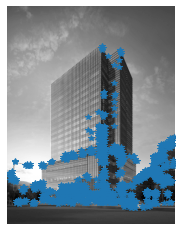

In [14]:
im = np.array(Image.open('/Users/sejongpyo/downloads/building.jpg').convert('L'))
harrisim = compute_harris_response(im)
filtered_coords = get_harris_points(harrisim, 6)
plot_harris_points(im, filtered_coords)

# 2.2 SIFT (Scale invariant feature transform)

- SIFT includes both an interest point detector and a descriptor.
- The descriptor is nowadays often combined with many different interest point detectors.
- SIFT features are invariant to scale, rotation and intensity and can be matched reliably across 3D viewpoint and noise.

#### Interest points
- SIFT interest point locations are found using difference-of-Gaussian functions.
- Interest point locator gives position and scale.

#### Descriptor
- To achieve invariance to rotation, a reference direction is chosen based on the direction and magnitude of the image gradient around each point.
- Compute a descriptor based on the position, scale and rotation.

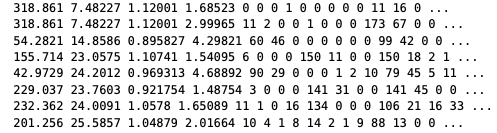
- each row contains the coordinates, scale and rotation angle for each interest point as the first 4 values.
- 128 values of the corresponding descriptor.

In [12]:
# The binaries need the image in grayscale .pgm format.
# the result is stored in a text file in an easy to read format.
def process_image(imagename, resultname, params="--edge-thresh 10 --peak-thresh 5"):
    '''Process an image and save the results in a file.'''
    
    if imagename[-3:] != 'pgm':
        # create a pgm file
        im = Image.open(imagename).convert('L')
        im.save('tmp.pgm')
        imagename = 'tmp.pgm'
        
    cmmd = str("sift "+imagename+" --output="+resultname+
               " "+params)
    os.system(cmmd)
    print('processed', imagename, 'to', resultname)

In [5]:
# read the features to Numpy arrays from an output file above.
def read_features_from_file(filename):
    '''Read feature properties and return in matrix form.'''
    
    f = np.loadtxt(filename)
    return f[:, :4], f[:, 4:] # feature locations, descriptors

def write_features_to_file(filename, locs, desc):
    '''Save feature location and descriptor to file.'''
    np.savetxt(filename, hstack((locs, desc)))
    
def plot_features(im, locs, circle = False):
    '''Show image with features.
       input : im (image as array),
               loc (row, col, scale, orientation of each feature).'''
    def draw_circle(c, r):
        t = np.arange(0, 1.01, .01)*2*pi
        x = r*cos(t) + c[0]
        y = r*sin(t) + c[1]
        plt.plot(x, y, 'b', linewidth = 2)
        
    plt.imshow(im)
    if circle:
        for p in locs:
            draw_circle(p[:2], p[2])
    else:
        plt.plot(locs[:, 0], locs[:, 1], 'ob')
    plt.axis('off')

In [29]:
pip install opencv-contrib-python

You should consider upgrading via the '/Users/sejongpyo/python_project/jupyter_kernels/py37/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [10]:
test = detector.detectAndCompute(im1, None)
test.shape

AttributeError: 'tuple' object has no attribute 'shape'

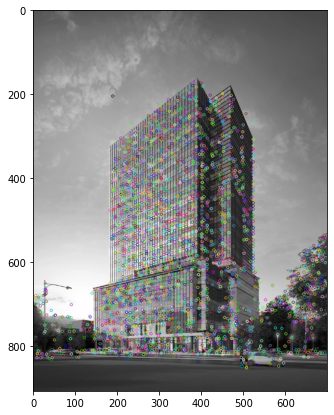

In [16]:
img = cv2.imread('building.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

sift = cv2.xfeatures2d.SIFT_create()
kp = sift.detect(gray, None)

img = cv2.drawKeypoints(gray, kp, outImage = None)

plt.figure(figsize= (10, 7))
plt.imshow(img)

#### Matching descriptors
- matching a feature in one image to a feature in another image is to use the ratio of the distance to the two closest matching features.